In [1]:
# Standard library imports
import random
from typing import Type, Any
from copy import deepcopy

# Third-party imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
import numpy as np

import gym_agent as ga

import KResRL.environment

from KResRL.policy.att_base import AttBlock, SAB, ISAB

/home/fool/Documents/code/Project/SOICT2025/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
n_games = 1000
max_t = 1500
n_envs = 1
chkpt_dir = "checkpoints/KRes-v0/DQN"

env_id = "KRes-v0"

seed = 110404

die_if_grass = True

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(
        self,
        NNBlock: AttBlock = SAB,
        n_layers: int = 2,
        embed_dim=128,
        num_heads: int = 4,
        d_ff: int = 256,
        dropout: float = 0.1,
        bias: bool = True,
        used_moe: bool = False,
        num_experts: int = 4,
        moe_top_k: int = 2,
        block_kwargs: dict[str, Any] = None,
    ):
        super().__init__()
        if block_kwargs is None:
            block_kwargs = {}

        self.att_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.att_layers.append(
                NNBlock(
                    embed_dim,
                    num_heads,
                    d_ff,
                    dropout,
                    bias,
                    used_moe,
                    num_experts,
                    moe_top_k,
                    **block_kwargs,
                )
            )

        self.dropout = nn.Dropout(p=dropout) if 0 <= dropout < 1 else nn.Identity()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            observations: [batch_size, n_drones, embed_dim]

        Returns:
            features: [batch_size, n_drones, embed_dim]
        """

        for layer in self.att_layers:
            X = layer(X)

        X = self.dropout(X)

        return X  # batch_size, n_drones, embed_dim

In [ ]:
class MLP(nn.Module):
    def __init__(self, inp_dim: int, hidden_dims: list[int], out_dim: int):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [inp_dim] + hidden_dims + [out_dim]

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Add ReLU activation function for all layers except the last one
            if i != len(layer_sizes) - 2:
                self.net.append(nn.ReLU(inplace=True))

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [ ]:
class DeepQNetwork(nn.Module):
    supported: list[AttBlock] = [SAB, ISAB]

    def __init__(
        self,
        feature_dim: int,
        encoder_hidden_dim: int,
        out_dim: int,

        NNBlock: AttBlock = SAB,
        n_layers: int = 2,
        embed_dim=128,
        num_heads: int = 4,
        d_ff: int = 256,
        dropout: float = 0.1,
        bias: bool = True,
        used_moe: bool = False,
        num_experts: int = 4,
        moe_top_k: int = 2,
        block_kwargs: dict[str, Any] = None,

        mlp_hidden_dims: list[int] = [256, 128],
    ):
        super().__init__()
        if block_kwargs is None:
            block_kwargs = {}

        # B x N x feat -> B x N x embed
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, encoder_hidden_dim),
            nn.ReLU(inplace=True),
            nn.LayerNorm(encoder_hidden_dim),  # helps stabilize before attention
            nn.Dropout(dropout, inplace=True),
            nn.Linear(encoder_hidden_dim, embed_dim),
            nn.ReLU(inplace=True),
            nn.LayerNorm(embed_dim),
        )

        # B x N x embed -> B x N x embed
        self.feature_extractor = FeatureExtractor(
            NNBlock=NNBlock,
            n_layers=n_layers,
            embed_dim=embed_dim,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            bias=bias,
            used_moe=used_moe,
            num_experts=num_experts,
            moe_top_k=moe_top_k,
            block_kwargs=block_kwargs,
        )

        # B x N x embed -> B x N x action
        self.mlp = MLP(
            embed_dim, mlp_hidden_dims, out_dim
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            observations: [batch_size, n_drones, embed_dim]

        Returns:
            features: [batch_size, n_drones, embed_dim]
        """

        X = self.encoder(X)             # B, n_drones, feature_dim -> B, n_drones, embed_dim
        X = self.feature_extractor(X)   # B, n_drones, embed_dim -> B, n_drones, embed_dim
        X = self.mlp(X)                 # B, n_drones, embed_dim -> B, n_drones, out_dim

        return X

In [ ]:
class Policy(nn.Module):
    def __init__(
        self,
        feature_dim: int,
        encoder_hidden_dim: int,
        out_dim: int,
        NNBlock: Type[AttBlock] = SAB,
        n_layers: int = 2,
        embed_dim: int = 128,
        num_heads: int = 4,
        d_ff: int = 256,
        dropout: float = 0.1,
        bias: bool = True,
        used_moe: bool = False,
        num_experts: int = 4,
        moe_top_k: int = 2,
        block_kwargs: dict[str, Any] = None,
        mlp_hidden_dims: list[int] = [256, 128],

        optimizer: Type[optim.Optimizer] = optim.Adam,
        lr: float = 5e-4,
        optimizer_kwargs: dict = None,
    ):
        super().__init__()

        self.network = DeepQNetwork(
            feature_dim=feature_dim,
            encoder_hidden_dim=encoder_hidden_dim,
            out_dim=out_dim,
            NNBlock=NNBlock,
            n_layers=n_layers,
            embed_dim=embed_dim,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            bias=bias,
            used_moe=used_moe,
            num_experts=num_experts,
            moe_top_k=moe_top_k,
            block_kwargs=block_kwargs,
            mlp_hidden_dims=mlp_hidden_dims,
        )

        self.target_network = DeepQNetwork(
            feature_dim=feature_dim,
            encoder_hidden_dim=encoder_hidden_dim,
            out_dim=out_dim,
            NNBlock=NNBlock,
            n_layers=n_layers,
            embed_dim=embed_dim,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            bias=bias,
            used_moe=used_moe,
            num_experts=num_experts,
            moe_top_k=moe_top_k,
            block_kwargs=block_kwargs,
            mlp_hidden_dims=mlp_hidden_dims,
        )

        if optimizer_kwargs is None:
            optimizer_kwargs = {}

        self.optimizer = optimizer(self.network.parameters(), lr=lr, **optimizer_kwargs)


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state)

    def target_forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.target_network(state)

    def soft_update(self, tau: float):
        for target_param, param in zip(
            self.target_network.parameters(), self.network.parameters()
        ):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

In [7]:
class DQN(ga.OffPolicyAgent):
    policy: Policy
    def __init__(
        self,
        policy: Policy,
        env,
        action_space,
        gamma=0.99,
        eps_start=1.0,
        eps_decay=0.995,
        eps_end=0.01,
        tau=1e-3,
        batch_size=64,
        update_every=1,
        name=None,
        device="auto",
        seed=None,
    ):
        super().__init__(
            policy,
            env,
            gamma=gamma,
            batch_size=batch_size,
            update_every=update_every,
            name=name,
            device=device,
            seed=seed,
        )

        self.action_space = action_space

        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_end = eps_end

        # Soft update parameter
        self.tau = tau

        self.target_policy = policy

        # Initialize epsilon for epsilon-greedy policy
        self.eps = eps_start

        self.soft_update(1)

    def reset(self):
        self.eps = max(self.eps_end, self.eps_decay * self.eps)

    @torch.no_grad()
    def predict(
        self, state: np.ndarray | dict[str, np.ndarray], deterministic=True
    ) -> int:
        # Determine epsilon value based on evaluation mode
        if deterministic:
            eps = 0
        else:
            eps = self.eps

        rng = random.random()

        if isinstance(state, dict):
            if rng >= eps:
                _state = {}

                for key, value in state.items():
                    _state[key] = torch.from_numpy(value).float().to(self.device)

                # Set local model to evaluation mode
                # Get action values from the local model
                self.policy.eval()
                action_value = self.policy.forward(_state)
                # Set local model back to training mode
                self.policy.train()

                # Return the action with the highest value
                return np.argmax(action_value.cpu().data.numpy(), axis=-1)
            else:
                # Return a random action from the action space
                return [
                    random.choice(self.action_space)
                    for _ in range(state["image"].shape[0])
                ]
        else:
            # Epsilon-greedy action selection
            if rng >= eps:
                # Convert state to tensor and move to the appropriate device
                state = torch.from_numpy(state).float().to(self.device)

                # Set local model to evaluation mode
                self.policy.eval()
                # Get action values from the local model
                action_value = self.policy.forward(state)
                # Set local model back to training mode
                self.policy.train()
                ret_action = np.argmax(action_value.cpu().data.numpy(), axis=-1)

                # Return the action with the highest value
                return ret_action
            else:
                # Return a random action from the action space
                ret_action = np.array([
                    self.dummy_env.action_space.sample() for _ in range(state.shape[0])
                ])
                return ret_action
                # return [random.choice(self.action_space) for _ in range(state.shape[0])]

    def learn(
        self,
        memory: ga.buffers.ReplayBuffer
    ):
        """
        Update the value network using a batch of experience tuples.

        Params
        ======
            states (Tensor): Batch of current states
            actions (Tensor): Batch of actions taken
            rewards (Tensor): Batch of rewards received
            next_states (Tensor): Batch of next states
            terminals (Tensor): Batch of terminal flags indicating episode end
        """

        samples = memory.sample(self.batch_size)

        states = samples.observations
        actions = samples.actions
        rewards = samples.rewards
        next_states = samples.next_observations
        terminals = samples.terminals

        # Get the maximum predicted Q values for the next states from the target model
        q_targets_next = self.policy.target_forward(next_states).detach().max(-1)[0]
        # Compute the Q targets for the current states

        q_targets = rewards.unsqueeze(1).repeat(1, q_targets_next.shape[-1]) + (self.gamma * q_targets_next * (~terminals.unsqueeze(1).repeat(1, q_targets_next.shape[-1])))

        # Get the expected Q values from the local model
        q_expected = self.policy.forward(states)


        q_expected = q_expected.gather(-1, actions.long().unsqueeze(-1)).squeeze(-1)


        # Compute the loss
        loss = F.smooth_l1_loss(q_expected, q_targets)

        # Minimize the loss
        self.policy.optimizer.zero_grad()
        loss.backward()
        self.policy.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self, tau=None):
        if tau is None:
            tau = self.tau

        self.policy.soft_update(tau)

In [8]:
env = ga.make_vec(env_id, num_envs=n_envs, n_drones=20, k=3, size=50, return_adj=False)

In [9]:
env.action_space

Box(0, 8, (1, 20), int64)

In [10]:
agent = DQN(
    policy = Policy(env.observation_space.shape[-1], 256, 9),
    env = env,
    action_space = list(range(4)),
    gamma=0.99,
    eps_start=1.0,
    eps_decay=0.995,
    eps_end=0.01,
    tau=1e-3,
    batch_size=64,
    update_every=4,
    device='auto',
    seed=seed
).to('cuda')


In [ ]:
agent.fit(total_timesteps=10000, save_best=True)

In [12]:
agent.load("./", "best")

In [13]:
options = {
    "drone_pos": [
        [0, 0],
        [0, 3],
        [3, 0],
        [3, 3],
        [1, 2]
    ]
}

options = None

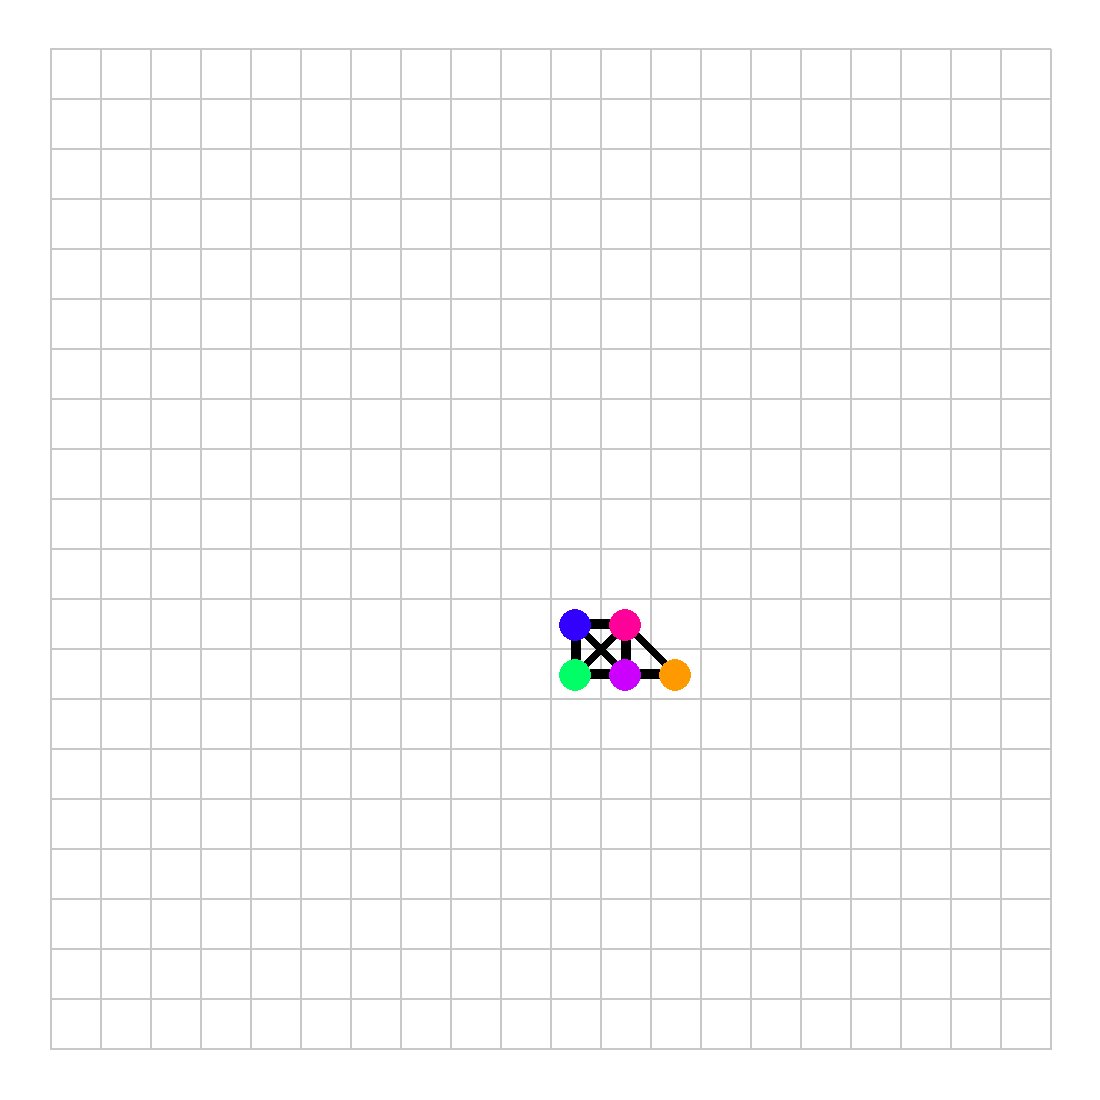

In [20]:
env = ga.make(env_id, n_drones=10, k=3, size=20, return_adj=False, render_mode="rgb_array", render_fps=1)
score, info = agent.play_jupyter(env, FPS=1,  options=options)

In [20]:
info["initial_pos"]

array([[8, 7],
       [3, 2],
       [4, 3],
       [5, 3],
       [4, 2],
       [2, 8],
       [3, 8],
       [9, 5],
       [1, 3],
       [4, 8]], dtype=uint16)

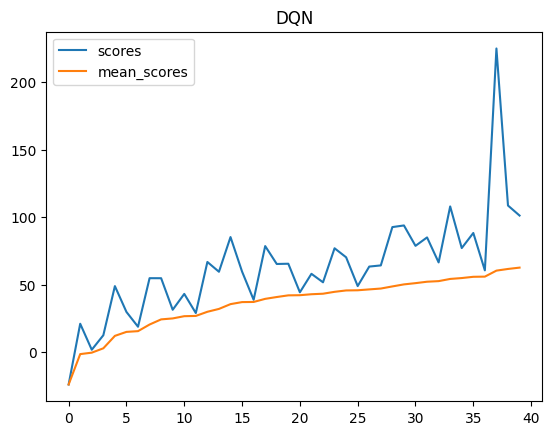

In [14]:
agent.plot_scores()